In [1]:
import pandas as pd

## All columns
''' 'date_time', 'site_name', 'posa_continent', 'user_location_country',
    'user_location_region', 'user_location_city',
    'orig_destination_distance', 'user_id', 'is_mobile', 'is_package',
    'channel', 'srch_ci', 'srch_co', 'srch_adults_cnt', 'srch_children_cnt',
    'srch_rm_cnt', 'srch_destination_id', 'srch_destination_type_id',
    'is_booking', 'cnt', 'hotel_continent', 'hotel_country', 'hotel_market',
    'hotel_cluster'
'''
## My opinion - mandatory columns
'''
srch_destination_id, is_booking, hotel_cluster, srch_adults_cnt
'''

In [2]:
NUMBER_OF_ROWS = 1000 # Train data is too big, get some rows
train_df = pd.read_csv('./expedia-hotel-recommendations/train.csv', nrows=NUMBER_OF_ROWS)

# Aggregation data
groupby1 = train_df.groupby(['srch_destination_id', 'hotel_cluster'])['is_booking'].agg(['count'])
groupby1.head()

count
srch_destination_id hotel_cluster       
267                 3                  1
                    30                 1
468                 26                 1
                    64                 1
669                 48                 4

In [3]:
# Convert single index dataframe
single_index_df = groupby1.reset_index(level=[0,1])
single_index_df

,srch_destination_id,hotel_cluster,count
0,267,3,1
1,267,30,1
2,468,26,1
3,468,64,1
4,669,48,4
...,...,...,...
460,63687,73,1
461,63687,90,2
462,65035,10,7
463,65035,35,1


In [4]:
# Collect hotel_cluster as list
def list_2_str(items):
    if (items is None) or (len(items) <= 0):
        return ''
    result = ''
    for item in items:
        result = result + str(item) + ','
    return result[:(len(result) - 1)]

total_count_of_hotel_cluster = 0 
destination_id_n_cluster_list = dict()
for index, row in single_index_df.iterrows():
    srch_destination_id = row['srch_destination_id']
    hotel_cluster = row['hotel_cluster']
    
    hotel_clusters = list()
    if srch_destination_id in destination_id_n_cluster_list:
        hotel_clusters = destination_id_n_cluster_list[srch_destination_id]
    hotel_clusters.append(hotel_cluster)
    total_count_of_hotel_cluster += 1
    destination_id_n_cluster_list[srch_destination_id] = hotel_clusters

destination_id_n_clusters = dict()
for key, value in destination_id_n_cluster_list.items():
    str_value = list_2_str(value)
    destination_id_n_clusters[key] = str_value

In [5]:
# Convert dict_list to dataframe
final_df = pd.DataFrame(destination_id_n_clusters.items(), columns=['srch_destination_id', 'hotel_clusters'])
final_df.head()

,srch_destination_id,hotel_clusters
0,267,"3,30"
1,468,"26,64"
2,669,"48,83"
3,1152,"8,66"
4,1385,58


# Train - Manual Implementation, 직접 구현

In [6]:
NUMBER_OF_ROWS = 5000 # Train data is too big, get some rows
test_df = pd.read_csv('./expedia-hotel-recommendations/test.csv', nrows=NUMBER_OF_ROWS, usecols=['srch_destination_id'])
test_df.head()

,srch_destination_id
0,12243
1,14474
2,11353
3,8250
4,11812


In [7]:
merged_test_df = test_df.merge(final_df, how = 'left')
merged_test_df[['hotel_clusters']] = merged_test_df[['hotel_clusters']].fillna(value = 'NA')
merged_test_df.head(10)

,srch_destination_id,hotel_clusters
0,12243,NA
1,14474,NA
2,11353,NA
3,8250,"1,24,45,71,79,84,88"
4,11812,NA
5,11827,NA
6,8271,NA
7,8291,"2,18,25,28"
8,8250,"1,24,45,71,79,84,88"
9,9145,NA


## Visualization

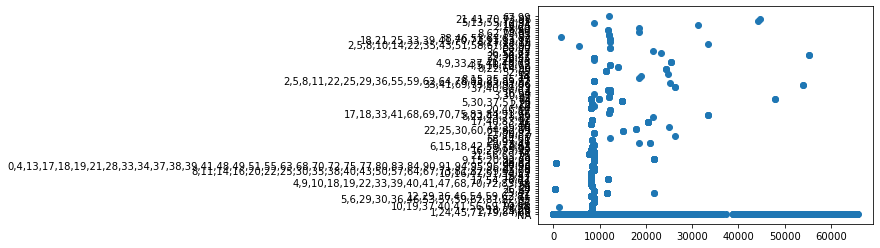

In [8]:
import matplotlib.pyplot as plt

plt.scatter(merged_test_df['srch_destination_id'].values, merged_test_df['hotel_clusters'].values)
plt.show()

# Train - K-Nearst Neighbor

In [9]:
# Aggregation data
NUMBER_OF_ROWS = 5000 # Train data is too big, get some rows
train_df = pd.read_csv('./expedia-hotel-recommendations/train.csv', nrows=NUMBER_OF_ROWS)
test_df = pd.read_csv('./expedia-hotel-recommendations/test.csv', nrows=NUMBER_OF_ROWS)

In [10]:
k_nearest_train_points = train_df[['srch_destination_id']]
k_nearest_train_labels = train_df[['hotel_cluster']]
k_nearest_test_points = test_df[['srch_destination_id']]

In [11]:
from sklearn.neighbors import KNeighborsClassifier

k_nearest_classifier = KNeighborsClassifier(n_neighbors = 100)
k_nearest_classifier.fit(k_nearest_train_points, k_nearest_train_labels)

<ipython-input-11-dfa5cc7f8660>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  k_nearest_classifier.fit(k_nearest_train_points, k_nearest_train_labels)


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=100, p=2,
                     weights='uniform')

In [12]:
k_nearest_result = k_nearest_classifier.predict(k_nearest_test_points)

## Visualization

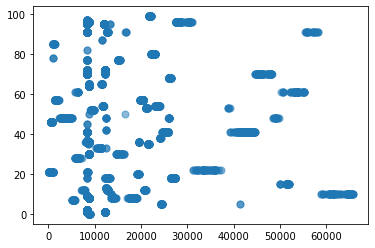

In [13]:
plt.scatter(k_nearest_test_points, k_nearest_result, s=50, alpha=0.5)
plt.show()

# Train - Agglomerative clustering

In [14]:
NUMBER_OF_ROWS = 5000 # Train data is too big, get some rows
train_df = pd.read_csv('./expedia-hotel-recommendations/train.csv', nrows=NUMBER_OF_ROWS)
test_df = pd.read_csv('./expedia-hotel-recommendations/test.csv', nrows=NUMBER_OF_ROWS)

agg_cluster_X = train_df[['srch_destination_id']]
agg_cluster_Y = train_df[['hotel_cluster']]
agg_cluster_destination_id = test_df[['srch_destination_id']]

In [15]:
from sklearn.cluster import AgglomerativeClustering

agglomerativeCluster = AgglomerativeClustering(n_clusters = 3, linkage = 'ward')
agglomerativeCluster.fit(agg_cluster_X, agg_cluster_Y)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=3)

In [16]:
agg_recommend_hotel = agglomerativeCluster.fit_predict(agg_cluster_destination_id)

## Visualization

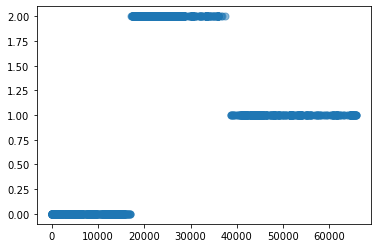

In [17]:
plt.scatter(agg_cluster_destination_id, agg_recommend_hotel, s = 50, alpha=0.5)
plt.show()